In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import cv2
import warnings
from PIL import Image
from glob import glob

plt.style.use('default')
sns.set_theme()
warnings.filterwarnings('ignore')

In [ ]:
%%capture
!unzip /content/sample_data/petfinder-pawpularity-score.zip

In [ ]:
train_df = pd.read_csv('train.csv')
print("Training data shape:", train_df.shape)
print("\nFirst few rows of the dataset:")
display(train_df.head())

Training data shape: (9912, 14)

First few rows of the dataset:


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [ ]:
#Get the image data (the .jpg data) and put it into lists of filenames
# train_images = glob("/content/train/*.jpg")
# print(f"Loaded {len(train_images)} images from train directory.")

train_img_dir = "/content/train/"
train_images = glob(os.path.join(train_img_dir, "*.jpg"))

#adding image path to train_df
train_df["image_path"] = train_df["Id"].apply(lambda x: os.path.join(train_img_dir, x + ".jpg"))

train_df = train_df[train_df["image_path"].isin(train_images)]

train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,image_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,/content/train/0007de18844b0dbbb5e1f607da0606e...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,/content/train/0009c66b9439883ba2750fb825e1d7d...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,/content/train/0013fd999caf9a3efe1352ca1b0d937...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,/content/train/0018df346ac9c1d8413cfcc888ca824...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,/content/train/001dc955e10590d3ca4673f034feeef...


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
class PetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        self.pawpularity_array = self.dataframe['Pawpularity'].astype('float32').values / 100.0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        # Load Image
        image = Image.open(row['image_path']).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.pawpularity_array[idx], dtype=torch.float32)
        return image, label


In [ ]:
def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation(degrees=45),
            transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
            transforms.ColorJitter(brightness=0.6, contrast=0.3, saturation=0.3, hue=0.2),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
            transforms.Grayscale(num_output_channels=3),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    else: # validation and test images resized without any transformation
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Train-validation split (80%-20%)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Create Dataset
train_dataset = PetDataset(train_data, transform=get_transforms(train=True))
val_dataset = PetDataset(val_data, transform=get_transforms(train=False))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Train Size: {len(train_data)}, Validation Size: {len(val_data)}")

Train Size: 7929, Validation Size: 1983


In [ ]:
import torch
import torch.nn as nn
import timm

class DeiTRegressor(nn.Module):
    def __init__(self):
        super(DeiTRegressor, self).__init__()

        # Load pretrained DeiT model (Base version)
        self.deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
        self.deit.set_grad_checkpointing(True)

        # Freeze all parameters by default
        for param in self.deit.parameters():
            param.requires_grad = False

        # Unfreeze the last two transformer blocks
        for block in self.deit.blocks[-2:]:  # Unfreeze last 2 layers
            for param in block.parameters():
                param.requires_grad = True

         # Get the feature size from DeiT
        deit_output_dim = self.deit.head.in_features

        # Remove the classification head
        self.deit.head = nn.Identity()

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(deit_output_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, images):
        features = self.deit(images)  # Extract features from DeiT
        output = self.regression_head(features)  # Regression prediction
        return output

In [ ]:
# Define custom RMSE loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, device='cuda', scheduler= None):
    model.to(device)
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0

        for images, scores in train_loader:
            images, scores = images.to(device), scores.to(device)


            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, scores)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, scores in val_loader:
                images, scores = images.to(device), scores.to(device)
                outputs = model(images)
                loss = criterion(outputs, scores)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("New best model saved!\n")

    # Plot Training & Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()


In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)

Using device cuda


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 42.6MB/s]


torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size

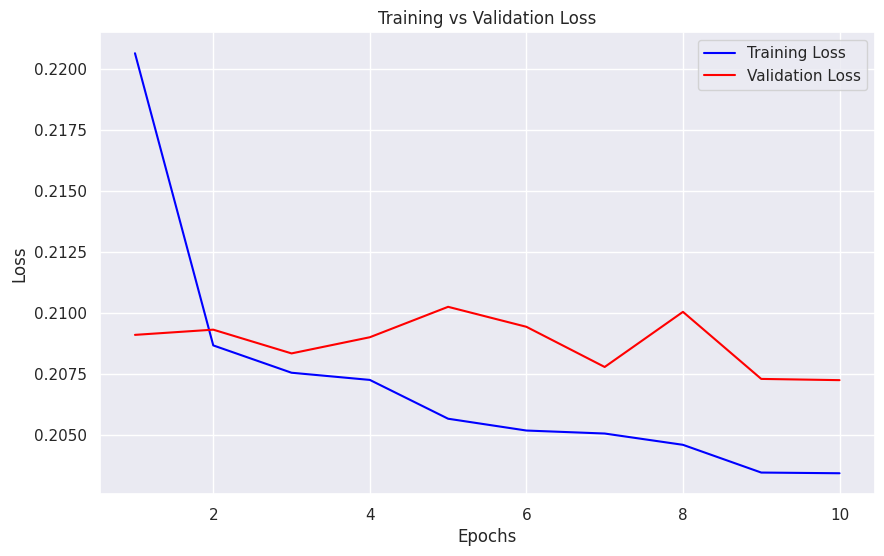

In [ ]:
import torch.optim as optim

# Initialize Model
model_deit = DeiTRegressor().to(device)

# Define Optimizer and Scheduler
optimizer = optim.AdamW(model_deit.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Define RMSE Loss
criterion = RMSELoss()

# Train the model
train_model(model_deit, train_loader, val_loader, criterion, optimizer, num_epochs=10, device= device, scheduler = scheduler)


In [ ]:
import torch
import torch.nn as nn
import timm

class DeiTBase(nn.Module):
    def __init__(self):
        super(DeiTBase, self).__init__()

        # Load pretrained DeiT model (Base version)
        self.deit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        self.deit.set_grad_checkpointing(True)

        # Freeze all parameters by default
        for param in self.deit.parameters():
            param.requires_grad = False

        # Unfreeze the last two transformer blocks
        for block in self.deit.blocks[-2:]:  # Unfreeze last 2 layers
            for param in block.parameters():
                param.requires_grad = True

         # Get the feature size from DeiT
        deit_output_dim = self.deit.head.in_features

        # Remove the classification head
        self.deit.head = nn.Identity()

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(deit_output_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, images):
        features = self.deit(images)  # Extract features from DeiT
        output = self.regression_head(features)  # Regression prediction
        return output

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:02<00:00, 159MB/s]


Epoch 1: Train Loss = 0.2237, Val Loss = 0.2175
New best model saved!

Epoch 2: Train Loss = 0.2089, Val Loss = 0.2161
New best model saved!

Epoch 3: Train Loss = 0.2084, Val Loss = 0.2091
New best model saved!

Epoch 4: Train Loss = 0.2062, Val Loss = 0.2093
Epoch 5: Train Loss = 0.2049, Val Loss = 0.2112
Epoch 6: Train Loss = 0.2050, Val Loss = 0.2074
New best model saved!

Epoch 7: Train Loss = 0.2045, Val Loss = 0.2074
Epoch 8: Train Loss = 0.2033, Val Loss = 0.2079
Epoch 9: Train Loss = 0.2029, Val Loss = 0.2074
Epoch 10: Train Loss = 0.2030, Val Loss = 0.2073
New best model saved!



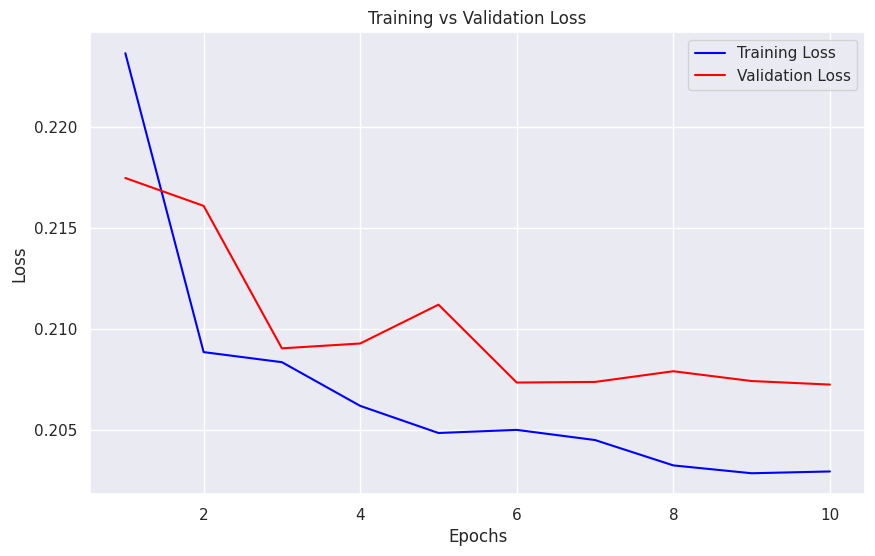

In [ ]:
import torch.optim as optim

# Initialize Model
model_deit_base = DeiTBase().to(device)

# Define Optimizer and Scheduler
optimizer = optim.AdamW(model_deit_base.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Define RMSE Loss
criterion = RMSELoss()

# Train the model
train_model(model_deit_base, train_loader, val_loader, criterion, optimizer, num_epochs=10, device= device, scheduler = scheduler)
